<a href="https://colab.research.google.com/github/BU-Spark/ds-bu-sustainability-waste/blob/team-1-JunyiZ/Predictive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/MyDrive/CS506/Spark
%ls
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy import stats

Mounted at /content/drive
/content/drive/MyDrive/CS506/Spark
DailyWeights.csv  date_temperature.csv  devs.csv        warren_trash.csv
Data/             devices.csv           trash_data.csv  weather.csv


In [ ]:
dw = pd.read_csv('DailyWeights.csv')
dw = dw[dw['Customer Key']>0]
dw['Customer Key'] = dw['Customer Key'].astype('int32')

In [ ]:
target = 'BU MED- 15 Stoughton'
warren = dw[dw['Location']==target]
warren_trash = warren[warren['Material']=='Trash'][['Work Order Date','Tons']]
warren_trash = warren_trash.groupby('Work Order Date').sum().reset_index()
warren_trash = warren_trash.rename(columns={'Work Order Date':'Date'})
warren_trash['Date'] = pd.to_datetime(warren_trash['Date'])
warren_trash = warren_trash.sort_values(by='Date')
warren_trash.head()

,Date,Tons
43,2021-07-09,6.17
40,2021-07-16,4.90
41,2021-07-23,4.71
42,2021-07-30,9.41
47,2021-08-07,5.97


In [ ]:
# Assuming your data is stored in a CSV file called 'trash_data.csv'
trash_data = warren_trash

# Calculate the interval between consecutive trash extraction dates
trash_data['Interval'] = trash_data['Date'].diff().dt.days

# Divide the trash output by the interval
trash_data['Trash'] = trash_data['Tons'] / trash_data['Interval']
trash_data.dropna(inplace=True)
trash_data.head()

,Date,Tons,Interval,Trash
41,2021-07-23,4.71,7.0,0.672857
42,2021-07-30,9.41,7.0,1.344286
47,2021-08-07,5.97,8.0,0.746250
44,2021-08-13,3.90,6.0,0.650000
45,2021-08-20,4.64,7.0,0.662857


In [ ]:
df = trash_data[['Date','Trash']]

# Set the DataFrame index to the 'Work Order Date' column
df.set_index('Date', inplace=True)

# Create a new date range covering all days between the first and last dates in the data
new_date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Reindex the DataFrame with the new date range
df_expanded = df.reindex(new_date_range)

# Forward-fill missing values in the 'Daily Output' column
df_expanded['Trash'].fillna(method='ffill', inplace=True)

# Reset the index of the resulting DataFrame
df_expanded.reset_index(inplace=True)
df_expanded.columns = ['Date', 'Trash']

print(df_expanded)

          Date     Trash
0   2021-07-23  0.672857
1   2021-07-24  0.672857
2   2021-07-25  0.672857
3   2021-07-26  0.672857
4   2021-07-27  0.672857
..         ...       ...
333 2022-06-21  0.458571
334 2022-06-22  0.458571
335 2022-06-23  0.458571
336 2022-06-24  0.458571
337 2022-06-25  0.446250

[338 rows x 2 columns]


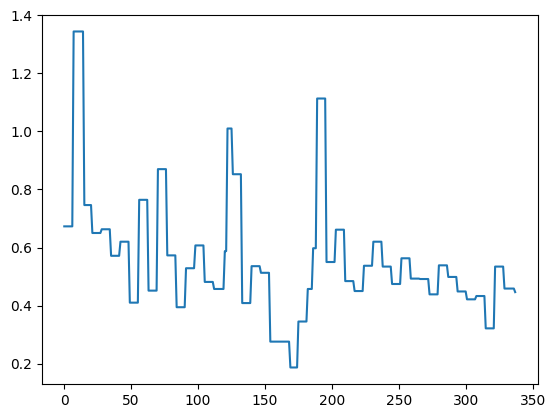

In [ ]:
plt.plot(df_expanded['Trash'])

In [ ]:
# Extract the month, day, and weekday from the 'Work Order Date' column
df = df_expanded
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek

df.head()

,Date,Trash,Month,Day,Weekday
0,2021-07-23,0.672857,7,23,4
1,2021-07-24,0.672857,7,24,5
2,2021-07-25,0.672857,7,25,6
3,2021-07-26,0.672857,7,26,0
4,2021-07-27,0.672857,7,27,1


In [ ]:
weather = pd.read_csv('weather.csv')
weather = weather[['DATE', 'AWND',
       'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WSF2']]
weather.head()

,DATE,AWND,PRCP,SNOW,TAVG,TMAX,TMIN,WDF2,WSF2
0,2021-01-01,6.26,0.10,0.0,34.0,36.0,29.0,320.0,17.0
1,2021-01-02,14.32,0.41,0.0,39.0,42.0,32.0,310.0,28.0
2,2021-01-03,9.40,0.03,0.2,33.0,36.0,29.0,20.0,17.0
3,2021-01-04,11.41,0.00,0.0,34.0,39.0,31.0,30.0,17.0
4,2021-01-05,10.74,0.01,0.0,32.0,33.0,30.0,340.0,15.0


In [ ]:
# Ensure the 'DATE' and 'Date' columns are in datetime format
weather['DATE'] = pd.to_datetime(weather['DATE'])
df['Date'] = pd.to_datetime(df['Date'])

# Merge the DataFrames by the 'DATE' and 'Date' columns
merged_df = df.merge(weather, left_on='Date', right_on='DATE')
merged_df.drop(columns='DATE',inplace=True)
merged_df['Date'] = merged_df['Date'].astype(str)
merged_df.head()

,Date,Trash,Month,Day,Weekday,AWND,PRCP,SNOW,TAVG,TMAX,TMIN,WDF2,WSF2
0,2021-07-23,0.672857,7,23,4,7.61,0.00,0.0,73.0,80.0,69.0,90.0,14.1
1,2021-07-24,0.672857,7,24,5,8.50,0.00,0.0,72.0,77.0,64.0,100.0,14.1
2,2021-07-25,0.672857,7,25,6,11.18,0.15,0.0,72.0,76.0,69.0,220.0,25.1
3,2021-07-26,0.672857,7,26,0,8.05,0.00,0.0,80.0,93.0,70.0,260.0,17.0
4,2021-07-27,0.672857,7,27,1,8.50,0.38,0.0,80.0,87.0,69.0,300.0,40.0


In [ ]:
from datetime import datetime

def get_period(date):
    summer_2021_start = datetime.strptime("2021-05-24", "%Y-%m-%d")
    summer_2021_end = datetime.strptime("2021-08-13", "%Y-%m-%d")
    fall_2021_start = datetime.strptime("2021-09-02", "%Y-%m-%d")
    fall_2021_end = datetime.strptime("2021-12-18", "%Y-%m-%d")
    spring_2022_start = datetime.strptime("2022-01-20", "%Y-%m-%d")
    spring_2022_end = datetime.strptime("2022-05-13", "%Y-%m-%d")
    summer_1_2022_start = datetime.strptime("2022-05-24", "%Y-%m-%d")
    summer_1_2022_end = datetime.strptime("2022-07-01", "%Y-%m-%d")
    summer_2_2022_start = datetime.strptime("2022-07-05", "%Y-%m-%d")
    summer_2_2022_end = datetime.strptime("2022-08-12", "%Y-%m-%d")

    if (summer_2021_start <= date <= summer_2021_end) or (summer_1_2022_start <= date <= summer_1_2022_end) or (summer_2_2022_start <= date <= summer_2_2022_end):
        return 2
    elif (fall_2021_start <= date <= fall_2021_end) or (spring_2022_start <= date <= spring_2022_end):
        return 1
    else:
        return 0
df = merged_df
# Apply the get_period function to the DataFrame
df["Period"] = df["Date"].apply(lambda x: get_period(datetime.strptime(x, "%Y-%m-%d")))
df.head()

,Date,Trash,Month,Day,Weekday,AWND,PRCP,SNOW,TAVG,TMAX,TMIN,WDF2,WSF2,Period
0,2021-07-23,0.672857,7,23,4,7.61,0.00,0.0,73.0,80.0,69.0,90.0,14.1,2
1,2021-07-24,0.672857,7,24,5,8.50,0.00,0.0,72.0,77.0,64.0,100.0,14.1,2
2,2021-07-25,0.672857,7,25,6,11.18,0.15,0.0,72.0,76.0,69.0,220.0,25.1,2
3,2021-07-26,0.672857,7,26,0,8.05,0.00,0.0,80.0,93.0,70.0,260.0,17.0,2
4,2021-07-27,0.672857,7,27,1,8.50,0.38,0.0,80.0,87.0,69.0,300.0,40.0,2


In [ ]:
import pandas as pd

# Assuming your dataframe is named 'df'

# One-hot encode the columns
month_encoded = pd.get_dummies(df['Month'], prefix='Month')
day_encoded = pd.get_dummies(df['Day'], prefix='Day')
weekday_encoded = pd.get_dummies(df['Weekday'], prefix='Weekday')
period_encoded = pd.get_dummies(df['Period'], prefix='Period')

# Combine the one-hot encoded columns with the original dataframe
df_encoded = pd.concat([df, month_encoded, day_encoded, weekday_encoded, period_encoded], axis=1)

# Drop the original columns from the dataframe
df = df_encoded.drop(columns=['Month', 'Day', 'Weekday', 'Period'])

# Display the one-hot encoded dataframe
df.head()


,Date,Trash,AWND,PRCP,SNOW,TAVG,TMAX,TMIN,WDF2,WSF2,...,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Period_0,Period_1,Period_2
0,2021-07-23,0.672857,7.61,0.00,0.0,73.0,80.0,69.0,90.0,14.1,...,0,0,0,0,1,0,0,0,0,1
1,2021-07-24,0.672857,8.50,0.00,0.0,72.0,77.0,64.0,100.0,14.1,...,0,0,0,0,0,1,0,0,0,1
2,2021-07-25,0.672857,11.18,0.15,0.0,72.0,76.0,69.0,220.0,25.1,...,0,0,0,0,0,0,1,0,0,1
3,2021-07-26,0.672857,8.05,0.00,0.0,80.0,93.0,70.0,260.0,17.0,...,1,0,0,0,0,0,0,0,0,1
4,2021-07-27,0.672857,8.50,0.38,0.0,80.0,87.0,69.0,300.0,40.0,...,0,1,0,0,0,0,0,0,0,1


Mean Squared Error: 0.06412051306817365


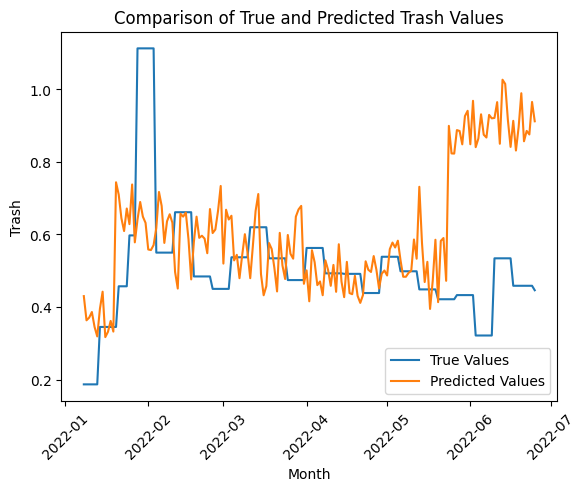

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop(columns=['Date',"Trash"])
y = df["Trash"]

# Split the dataset into training and testing sets
n_samples = len(X)
test_size = int(0.5 * n_samples)
train_start = test_size
train_end = n_samples - test_size

# Create training and test sets using the calculated indices
X_train, X_test = X.iloc[:train_end], X.iloc[train_end:]
y_train, y_test = y.iloc[:train_end], y.iloc[train_end:]

# Create and train the LightGBM model
model = LGBMRegressor()
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the DATE column to datetime objects
df["Date"] = pd.to_datetime(df["Date"])

# Get the date values for the test set
test_dates = df["Date"].iloc[train_end:]

# Create the line plot
fig, ax = plt.subplots()

# Plot the true and predicted values
ax.plot(test_dates, y_test, label="True Values",)
ax.plot(test_dates, y_pred, label="Predicted Values",)

# Format the x-axis to display months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Add a legend, labels, and a title
ax.legend()
ax.set_xlabel("Month")
ax.set_ylabel("Trash")
ax.set_title("Comparison of True and Predicted Trash Values")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


Mean Squared Error: 0.07293176954119227


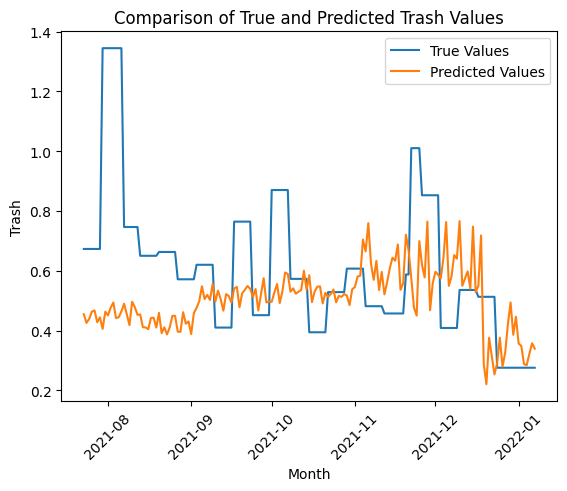

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df.drop(columns=['Date',"Trash"])
y = df["Trash"]

# Split the dataset into training and testing sets
n_samples = len(X)
test_size = int(0.5 * n_samples)
train_start = test_size
train_end = n_samples - test_size

# Create training and test sets using the calculated indices
X_train, X_test = X.iloc[train_end:], X.iloc[:train_end]
y_train, y_test = y.iloc[train_end:], y.iloc[:train_end]

# Create and train the LightGBM model
model = LGBMRegressor()
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert the DATE column to datetime objects
df["Date"] = pd.to_datetime(df["Date"])

# Get the date values for the test set
test_dates = df["Date"].iloc[:train_end]

# Create the line plot
fig, ax = plt.subplots()

# Plot the true and predicted values
ax.plot(test_dates, y_test, label="True Values",)
ax.plot(test_dates, y_pred, label="Predicted Values",)

# Format the x-axis to display months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Add a legend, labels, and a title
ax.legend()
ax.set_xlabel("Month")
ax.set_ylabel("Trash")
ax.set_title("Comparison of True and Predicted Trash Values")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
X.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            328, 329, 330, 331, 332, 333, 334, 335, 336, 337],
           dtype='int64', length=338)

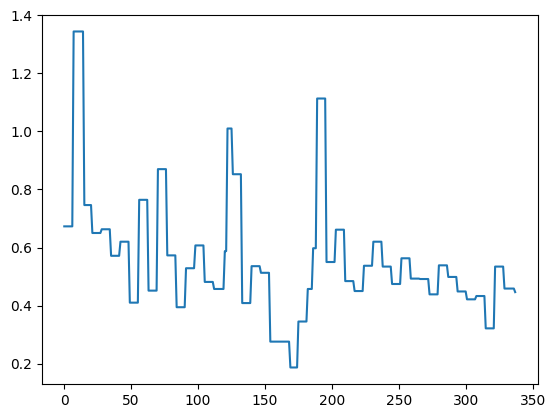

In [ ]:
plt.plot(df_expanded['Trash'])